# MPLS L3VPNs Miscellaneus

### Notes:
1. Route Leaking
2. Hub and Spoke
3. L3VPNs and CoS
4. BGP PIC Edge and Provider Edge Link Protection
5. VRFs and Internet Access

### Lab Examples:
1. Hub and Spoke

## 1) Route Leaking

* RIB Groups or auto-export
    * auto-export
        * Checks the vrf-import, vrf-export and/or vrf-target
    ```
        set routing-instances VPN-A instance-type vrf
        set routing-instances VPN-A interface ge-0/0/2.42
        set routing-instances VPN-A vrf-target target:64512:100
        set routing-instances VPN-A routing-options auto-export <---
        
        set routing-instances VPN-B instance-type vrf
        set routing-instances VPN-B interface ge-0/0/2.53
        set routing-instances VPN-B vrf-target target:64512:100
        set routing-instances VPN-B routing-options auto-export <---if route-targets permit, enables leaking
    ```
    * RIB-Groups
    ```
        set routing-options rib-groups A-to-B import-rib [ VPN-A.inet.0 VPN-B.inet.0 ]
        set routing-options rib-groups A-to-B import-policy POL_A_B_LEAK
        set routing-instances VPN-A routing-options interface-routes rib-group inet A-to-B
        set routing-instances VPN-A protocols bgp group BGP-VPN-A type faminly inet unicast rib-group A-to-B
        
        set routing-options rib-groups B-to-A import-rib [ VPN-B.inet.0 VPN-A.inet.0 ]
        set routing-instances VPN-B routing-options interface-routes rib-group inet B-to-A
        set routing-instances VPN-B protocols bgp group BGP-VPN-B type faminly inet unicast rib-group B-to-A
    ``` 


## 2) Hub-and-Spoke

* Requires two VRF instances at on the hub PE and hub CE-to-PE link
    * Spoke instance imports routes from spoke PEs and send to the hub CE
    * Hub instance receives routes from the hub CE and exports to PE spokes
* Requires two route-targets
* Cannot use `vrf-target`

### Spoke
```
set routing-instances SPOKE-A instance-type vrf
set routing-instances SPOKE-A interface ge-0/0/2.378
set routing-instances SPOKE-A route-distinguisher 10.22.22.22:378
set routing-instances SPOKE-A vrf-import SPOKE-A-import
set routing-instances SPOKE-A vrf-export SPOKE-A-export
set routing-instances SPOKE-A protocols bgp group EXTERNAL type external
set routing-instances SPOKE-A protocols bgp group EXTERNAL peer-as 64513
set routing-instances SPOKE-A protocols bgp group EXTERNAL as-override
set routing-instances SPOKE-A protocols bgp group EXTERNAL neighbor 10.x.x.x

set policy-options policy-statement SPOKE-A-import term 1 from protocol bgp
set policy-options policy-statement SPOKE-A-import term 1 from community hub
set policy-options policy-statement SPOKE-A-import term 1 then accept
set policy-options policy-statement SPOKE-A-import term 2 then reject

set policy-options policy-statement SPOKE-A-export term 1 from protocol [bgp static direct]
set policy-options policy-statement SPOKE-A-export term 1 then community add spoke
set policy-options policy-statement SPOKE-A-export term 1 then accept
set policy-options policy-statement SPOKE-A-export term 2 then reject

set policy-options community hub members target:64512:873
set policy-options community spoke members target:64512:378
```

### Hub
```
# HUB VRF sends routes out to the spoke PEs
set routing-instances HUB-A instance-type vrf
set routing-instances HUB-A routing-options autonomous-system loops 2
set routing-instances HUB-A interface ge-0/0/2.873
set routing-instances HUB-A route-distinguisher 10.22.22.22:873
set routing-instances HUB-A vrf-import null
set routing-instances HUB-A vrf-export hub-out

set routing-instances HUB-A protocols bgp group HUB_EXTERNAL type external
set routing-instances HUB-A protocols bgp group HUB_EXTERNAL peer-as 64513
set routing-instances HUB-A protocols bgp group HUB_EXTERNAL neighbor 10.x.x.x

# SPOKE VRF receives routes from the spoke PEs
set routing-instances SPOKE-A instance-type vrf
set routing-instances SPOKE-A interface ge-0/0/2.378
set routing-instances SPOKE-A route-distinguisher 10.22.22.22:378
set routing-instances SPOKE-A vrf-import spoke-in
set routing-instances SPOKE-A vrf-export null

set routing-instances SPOKE-A protocols bgp group SPOKE_EXTERNAL type external
set routing-instances SPOKE-A protocols bgp group SPOKE_EXTERNAL peer-as 64513
set routing-instances SPOKE-A protocols bgp group SPOKE_EXTERNAL as-overrride
set routing-instances SPOKE-A protocols bgp group SPOKE_EXTERNAL neighbor 10.x.x.x


set policy-options policy-statement spoke-in from protocol bgp
set policy-options policy-statement spoke-in from community spoke
set policy-options policy-statement spoke-in then accept

set policy-options policy-statement hub-out from protocol bgp
set policy-options policy-statement hub-out then community add hub
set policy-options policy-statement hub-out then accept

set policy-options policy-statement null then reject

set policy-options community hub members target:64512:873
set policy-options community spoke members target:64512:378
```


## 3) VPNs and CoS
* Use the MPLS exp bits (3-bits)
* Egress filtering requires `vrf-table-label` and VT interface

### Example CoS config
```
######################
### Ingress Router ###
######################
set firewall family inet filter lab-exp term 1 from source-address 10.42.42.0/24
set firewall family inet filter lab-exp term 1 then forwarding-class assured-forwarding
set firewall family inet filter lab-exp term 1 then loss-priority high
set firewall family inet filter lab-exp term 2 then accept
set interfaces ge-0/0/2 unit 42 family inet filter input lab-exp

################
### All LSRs ###
################
set class-of-service classifiers exp VPN-class fowarding-class assured-forwarding loss-priority high code-point 101
set class-of-service classifiers exp VPN-class fowarding-class best-effort loss-priority low code-point 000
set class-of-service classifiers exp VPN-class fowarding-class expedited-forwarding loss-priority high code-point 111
set class-of-service classifiers exp VPN-class fowarding-class network-control loss-priority high code-point 001

set class-of-service schedulers af transmit-rate percent 50
set class-of-service schedulers af priority high
set class-of-service schedulers be transmit-rate remainder
set class-of-service schedulers be priority low
set class-of-service schedulers ef transmit-rate percent 20
set class-of-service schedulers ef priority high
set class-of-service schedulers nc transmit-rate percent 10
set class-of-service schedulers nc priority high

set scheduler-maps VPN-map forwarding-class assured-forwarding scheduler af
set scheduler-maps VPN-map forwarding-class best-effort scheduler be
set scheduler-maps VPN-map forwarding-class expediated-forwarding scheduler ef
set scheduler-maps VPN-map forwarding-class network-control scheduler nc

set class-of-service rewrite-rules exp VPN-rewrite fowarding-class assured-forwarding loss-priority high code-point 101
set class-of-service rewrite-rules exp VPN-rewrite fowarding-class best-effort loss-priority low code-point 000
set class-of-service rewrite-rules exp VPN-rewrite fowarding-class expedited-forwarding loss-priority high code-point 111
set class-of-service rewrite-rules exp VPN-rewrite fowarding-class network-control loss-priority high code-point 001

##################################
### All Core-facing interfaces ###
##################################
set class-of-service interfaces ge-0/0/x unit 0 classifiers exp VPN-class
set class-of-service interfaces ge-0/0/x unit 0 rewrite-rules exp VPN-rewrite

################
### ALL PEs ### 
################
set protocols mpls explicit-null

//------------------------------------//
//------------------------------------//
//------------------------------------//

#######################
### Static CoS LSPs ### 
#######################

set protocols mpls label-switched-path PE_PAR1_GOLD_PE_FRA5 to 10.55.55.55
set protocols mpls label-switched-path PE_PAR1_GOLD_PE_FRA5 class-of-service 4

##################################
### VPN Prefix LSP mapping PEs ### 
##################################

set policy-options policy-statement lsp-prefix-map term 1 from community gold
set policy-options policy-statement lsp-prefix-map term 1 then install-nexthop lsp PE11_HBW_PE22
set policy-options policy-statement lsp-prefix-map term 1 then accpt
set policy-options policy-statement lsp-prefix-map term 2 from community silver
set policy-options policy-statement lsp-prefix-map term 2 then install-nexthop lsp PE11_PE22
set policy-options policy-statement lsp-prefix-map term 2 then accpt
set routing-options forwarding-table export lsp-prefix-map

```



## 4.a) BGP PIC Edge
* backup VPN path installed in the forwarding table for traffic destined to multi-homed CE
* backup path used until the IGP reconverges
* Configure on Egress Router

```
set policy-options policy-statement LB then load-balance per-packet
set routing-options forwarding-table export LB

set routing-instances PROTECTED-VPN routing-options protect core                   <----

show route extensive table PROTECTED-VPN.inet.0 x.x.x.x/x
# Check the weight: 0x1 main, 0x4000: backup
show route forwarding-table table PROTECTED-VPN destination x.x.x.x/x
```

## 4.b) Provider Edge Link Protection
* like BGP PIC Edge, but in the opposite direction (prefixes from multihomed CE)
* Configure on Ingress Router

```
set policy-options policy-statement LB then load-balance per-packet
set routing-options forwarding-table export LB

set routing-instances PROTECTED-VPN protocols bgp family inet unicast protection   <---- 

show route extensive table PROTECTED-VPN.inet.0 x.x.x.x/x
# Check the weight
show route forwarding-table table PROTECTED-VPN destination x.x.x.x/x
```

## 5) Internet Access

* Accidentally deleted my notes here and need to add them back in (but sample config of one option below):

```
# CLIENT_PUBLIC_IP will be configured on the client CE and used by the client for NAT

set routing-options rib-groups inet0_VPN-A import-rib [ inet.0 VPN-A.inet.0 ]
set routing-options rib-groups inet0_VPN-A import-policy rib-routes

set routing-options interface-routes rib-group inet inet0_VPN-a
set routing-options static route <CLIENT_PUBLIC_IP>/32 next-table VPN-A.inet.0                        <---needed for the return traffic to VPN-A

set policy-options policy-statement rib-routes term CORE-INTERFACES from interface ge-0/0/x.0         <---Needed to resolve next-hop for default route
set policy-options policy-statement rib-routes term CORE-INTERFACES then accept
set policy-options policy-statement rib-routes term DEFAULT-ROUTE from route-filter 0.0.0.0/0 exact   <---accept the default route in VPN-A
set policy-options policy-statement rib-routes term DEFAULT-ROUTE then accept
set policy-options policy-statement rib-routes term REJECT then reject

set protocols bgp group GW type internal
set protocols bgp group GW export send_VPN-A
set protocols bgp group GW neighbor 10.2.2.2
set protocols bgp group GW family inet unicast rib-group inet0_VPN-A

set policy-option policy-statement send_VPN-A term 1 from protocol static
set policy-option policy-statement send_VPN-A term 1 from route-filter <CLIENT_PUBLIC_IP>/32 exact  <---Share the client's Publically routeable IP with the GW
set policy-option policy-statement send_VPN-A term 1 then accept
```

## Topology
* Physical Topology from EVE-NG
* TODO: Draw up logical topology
* All core P devices are running basic Cisco IOS images as these require less resources. They are configured with basic MPLS/LDP/ISIS.
* Customer devices are set up as Logical-Systems on the vMXs and connected via the EVE-NG bridges, except for the multihomed client, CE-42-MH, and the multihomed OSPF site (connected with a backdoor link) running as a Cisco IOS device.
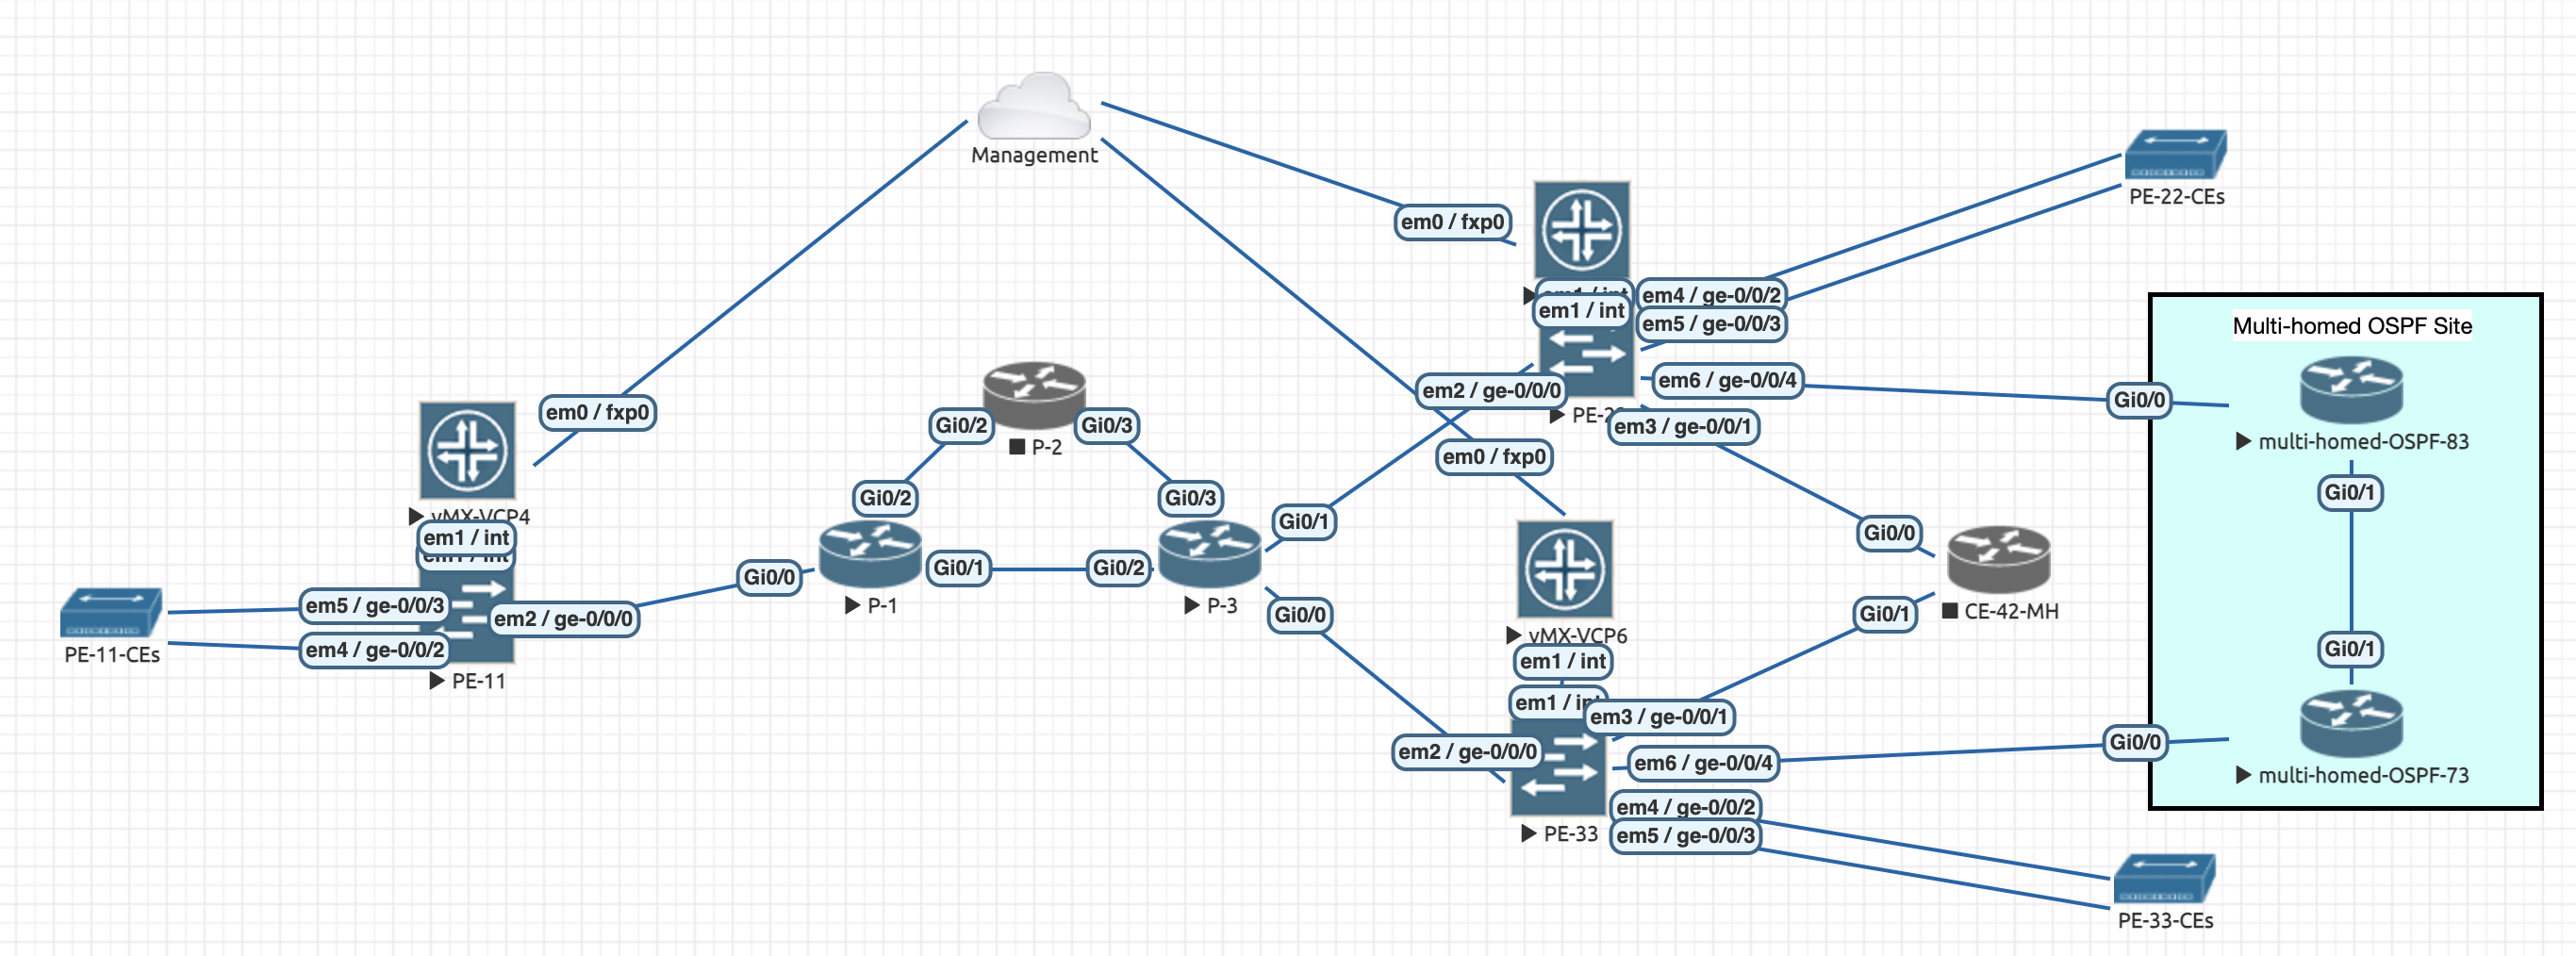

In [2]:
import logging
import os
from nornir import InitNornir
from nornir_utils.plugins.functions import print_result
from nornir_napalm.plugins.tasks import napalm_get, napalm_cli, napalm_configure
from nornir.core.task import Task, Result
from nornir.core.filter import F

In [3]:
nr = InitNornir(config_file="nornir_inventory/config.yml")

In [4]:

#############################
# Backup/Restore  Functions #
#############################

def backup_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Backs up running configurations from all devices in Nornir inventory."""
    os.makedirs(backup_dir, exist_ok=True)
    def backup_config(task):
        result = task.run(task=napalm_get, getters=["config"])
        config_data = result.result["config"]["running"]
        if not file_name_suffix:
            backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
        else:
            backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
        with open(backup_filename, "w") as backup_file:
            backup_file.write(config_data)
        print(f"Backup saved: {backup_filename}")
    nr.run(task=backup_config)

def restore_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Restores all device configurations from the latest backup in the specified folder."""
    def restore_config(task):
        try:
            if not file_name_suffix:
                backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
            else:
                backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
            with open(backup_filename, "r") as file:
                config_data = file.read()
            task.run(task=napalm_configure, configuration=config_data, replace=True)
            print(f"Configuration restored for {task.host} from {backup_filename}")
        except Exception as err:
            print(f"No backup not found for {task.host}")
            print(err)
    nr.run(task=restore_config)

#################################
# Verification Helper Functions #
#################################

def _run_verify_commands(task, commands):
    task.run(task=napalm_cli, commands=commands)
    
def verify_commands(nr, commands):
    result = nr.run(_run_verify_commands, commands=commands)
    for device in result.keys():
        for command in result[device][1].result.keys():
            header = f"{device} - {command}:"
            delimiter = len(header) * '-'
            print(delimiter)
            print(header)
            print(delimiter)
            print(result[device][1].result[command])
    return result


In [32]:
# Backup lab to start
#backup_all_configs(nr)
restore_all_configs(nr, file_name_suffix="base_bgp_and_ospf")

Configuration restored for PE-11 from backups/PE-11_base_bgp_and_ospf_backup.conf
Configuration restored for PE-22 from backups/PE-22_base_bgp_and_ospf_backup.conf
Configuration restored for PE-33 from backups/PE-33_base_bgp_and_ospf_backup.conf


## Hub and Spoke Lab Example
[Juniper L3VPN Hub and Spoke Doc](https://www.juniper.net/documentation/us/en/software/junos/vpn-l3/topics/topic-map/l3-vpns-hub-spoke.html)

* PE22 and PE33 will function as spokes in this example
* PE11 will function as the hub
* CEs will be configured as Logical-Systems

### Hub and Spoke PE Routers:

In [33]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def spoke_pe(task):
    """
    Apply spoke configuration to PEs using Nornir/Napalm
    """
    third = task.host.data['unique_octet']
    loopback = task.host.data['loopback']
    spoke_config = [ 
        "set policy-options community hub members target:64512:873",
        "set policy-options community spoke members target:64512:378",
    ]
    try:
        name = "VPN-SPOKE"

        spoke_config.append(f"set routing-instances {name} instance-type vrf")
        spoke_config.append(f"set routing-instances {name} interface ge-0/0/2.378")
        spoke_config.append(f"set routing-instances {name} route-distinguisher {loopback}:378")
        spoke_config.append(f"set routing-instances {name} vrf-import {name}-import")
        spoke_config.append(f"set routing-instances {name} vrf-export {name}-export")
        spoke_config.append(f"set routing-instances {name} protocols bgp group EXTERNAL type external")
        spoke_config.append(f"set routing-instances {name} protocols bgp group EXTERNAL peer-as 64513")
        spoke_config.append(f"set routing-instances {name} protocols bgp group EXTERNAL as-override")
        spoke_config.append(f"set routing-instances {name} routing-options autonomous-system 64512 loops 1")
        spoke_config.append(f"set routing-instances {name} protocols bgp group EXTERNAL neighbor 10.37.{third}.2")
        
        spoke_config.append(f"set policy-options policy-statement {name}-import term 1 from protocol bgp")
        spoke_config.append(f"set policy-options policy-statement {name}-import term 1 from community hub")
        spoke_config.append(f"set policy-options policy-statement {name}-import term 1 then accept")
        spoke_config.append(f"set policy-options policy-statement {name}-import term 2 then reject")
        
        spoke_config.append(f"set policy-options policy-statement {name}-export term 1 from protocol [bgp static direct]")
        spoke_config.append(f"set policy-options policy-statement {name}-export term 1 then community add spoke")
        spoke_config.append(f"set policy-options policy-statement {name}-export term 1 then accept")
        spoke_config.append(f"set policy-options policy-statement {name}-export term 2 then reject")
                                
        spoke_config = "\n".join(spoke_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=spoke_config)
    except Exception as err:
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")
        print("Error:", err)

In [34]:
pe22_pe33 = nr.filter(F(name="PE-22") | F(name="PE-33"))
result = pe22_pe33.run(spoke_pe)
print_result(result, severity_level=logging.DEBUG)

spoke_pe************************************************************************
* PE-22 ** changed : True ******************************************************
vvvv spoke_pe ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit policy-options]
+   policy-statement VPN-SPOKE-export {
+       term 1 {
+           from protocol [ bgp static direct ];
+           then {
+               community add spoke;
+               accept;
+           }
+       }
+       term 2 {
+           then reject;
+       }
+   }
+   policy-statement VPN-SPOKE-import {
+       term 1 {
+           from {
+               protocol bgp;
+               community hub;
+           }
+           then accept;
+       }
+       term 2 {
+           then reject;
+       }
+   }
[edit policy-options]
+   community hub members target:64512:873;
+   community spoke members target:64512:378;
[edit routing-insta

In [35]:
nr = InitNornir(config_file="nornir_inventory/config.yml")
def hub_pe(task):
    """
    Apply hub configuration to PE using Nornir/Napalm
    """
    third = task.host.data['unique_octet']
    loopback = task.host.data['loopback']
    hub_config = [ 
        "set policy-options policy-statement spoke-in from protocol bgp",
        "set policy-options policy-statement spoke-in from community spoke",
        "set policy-options policy-statement spoke-in then accept",
        
        "set policy-options policy-statement hub-out from protocol bgp",
        "set policy-options policy-statement hub-out then community add hub",
        "set policy-options policy-statement hub-out then accept",
        
        "set policy-options policy-statement null then reject",
        
        "set policy-options community hub members target:64512:873",
        "set policy-options community spoke members target:64512:378",
    ]
    try:
        name_spoke = "VPN-SPOKE"
        name_hub = "VPN-HUB"
        # HUB VRF sends routes out to the spoke PEs
        hub_config.append(f"set routing-instances {name_hub} instance-type vrf")
        hub_config.append(f"set routing-instances {name_hub} routing-options autonomous-system 64512 loops 1")
        hub_config.append(f"set routing-instances {name_hub} interface ge-0/0/2.873")
        hub_config.append(f"set routing-instances {name_hub} route-distinguisher {loopback}:873")
        hub_config.append(f"set routing-instances {name_hub} vrf-import null")
        hub_config.append(f"set routing-instances {name_hub} vrf-export hub-out")
        
        hub_config.append(f"set routing-instances {name_hub} protocols bgp group HUB_EXTERNAL type external")
        hub_config.append(f"set routing-instances {name_hub} protocols bgp group HUB_EXTERNAL peer-as 64513")
        hub_config.append(f"set routing-instances {name_hub} protocols bgp group HUB_EXTERNAL neighbor 10.87.{third}.2")
        
        # SPOKE VRF receives routes from the spoke PEs
        hub_config.append(f"set routing-instances {name_spoke} instance-type vrf")
        hub_config.append(f"set routing-instances {name_spoke} interface ge-0/0/2.378")
        hub_config.append(f"set routing-instances {name_spoke} route-distinguisher {loopback}:378")
        hub_config.append(f"set routing-instances {name_spoke} vrf-import spoke-in")
        hub_config.append(f"set routing-instances {name_spoke} vrf-export null")
        
        hub_config.append(f"set routing-instances {name_spoke} protocols bgp group SPOKE_EXTERNAL type external")
        hub_config.append(f"set routing-instances {name_spoke} protocols bgp group SPOKE_EXTERNAL peer-as 64513")
        hub_config.append(f"set routing-instances {name_spoke} protocols bgp group SPOKE_EXTERNAL as-override")
        hub_config.append(f"set routing-instances {name_spoke} protocols bgp group SPOKE_EXTERNAL neighbor 10.37.{third}.2")

        hub_config = "\n".join(hub_config)
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration=hub_config)
    except Exception as err:
        task.run(task=napalm_configure, severity_level=logging.DEBUG, configuration="rollback 0")
        print("Error:", err)

In [36]:
pe11 = nr.filter(F(name="PE-11"))
result = pe11.run(hub_pe)
print_result(result, severity_level=logging.DEBUG)

hub_pe**************************************************************************
* PE-11 ** changed : True ******************************************************
vvvv hub_pe ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
---- napalm_configure ** changed : True ---------------------------------------- DEBUG
[edit policy-options]
+   policy-statement hub-out {
+       from protocol bgp;
+       then {
+           community add hub;
+           accept;
+       }
+   }
+   policy-statement null {
+       then reject;
+   }
+   policy-statement spoke-in {
+       from {
+           protocol bgp;
+           community spoke;
+       }
+       then accept;
+   }
[edit policy-options]
+   community hub members target:64512:873;
+   community spoke members target:64512:378;
[edit routing-instances]
+   VPN-HUB {
+       instance-type vrf;
+       interface ge-0/0/2.873;
+       route-distinguisher 10.11.11.11:873;
+       vrf-import null;
+       vrf-export hub-out;
+

### Hub and Spoke CEs (logical-systems):

In [37]:
# TODO: H-&-S CEs

Socket exception: Operation timed out (60)
